# Week4授業課題 信用情報を学習しよう

## 【問題1】パイプラインの作成

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


df_train = pd.read_csv('application_train.csv')
df_X = df_train.drop("TARGET", axis=1)
df_Y = df_train[["TARGET"]]

#カテゴリーを数値変換
categorical_feats = [
    f for f in df_X.columns if df_X[f].dtype == 'object'
]
categorical_feats_ = categorical_feats.copy()

for f in categorical_feats_:
    df_X[f], _ = pd.factorize(df_X[f])
    df_X[f] = df_X[f].astype('int')
    
#残りの欠損値を平均で埋める
df_X = df_X.fillna(df_X.mean())

#データ分割
(X_train, X_test, 
     y_train, y_test) = train_test_split(df_X.values, df_Y.values.flatten(), test_size=0.25)

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression().fit(X_train, y_train)
y_predict_logistic = clf_logistic.predict(X_test)
y_predict_proba_logistic = clf_logistic.predict_proba(X_test)

/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [4]:
estimation_logistic_dict = {
    "accuracy": accuracy_score(y_test, y_predict_logistic),
    "precision": precision_score(y_test, y_predict_logistic),
    "recall": recall_score(y_test, y_predict_logistic),
    "f1":f1_score(y_test, y_predict_logistic)
}

estimation_logistic = pd.DataFrame(estimation_logistic_dict, index=['LogisticRegression'])
estimation_logistic

,accuracy,precision,recall,f1
LogisticRegression,0.919015,0.453237,0.01014,0.019836


In [5]:
"""
テストデータを読み込み、処理
"""

df_apptest = pd.read_csv('application_test.csv')

#カテゴリーを数値変換
categorical_feats = [
    f for f in df_apptest.columns if df_apptest[f].dtype == 'object'
]
categorical_feats_ = categorical_feats.copy()

for f in categorical_feats_:
    df_apptest[f], _ = pd.factorize(df_apptest[f])
    df_apptest[f] = df_apptest[f].astype('int')
    
#残りの欠損値を平均で埋める
df_apptest = df_apptest.fillna(df_apptest.mean())

X_apptest = df_apptest.values

#標準化
scaler.fit(X_apptest)
X_apptest = scaler.transform(X_apptest)

In [6]:
len(X_apptest)

48744

In [7]:
#予測
y_apt_predict_logistic = clf_logistic.predict(X_apptest)

In [8]:
"""
csvファイルへ書き込み
"""

import csv as csv

submit_file = open("home_credit_submit.csv", "w")
file_object = csv.writer(submit_file)
file_object.writerow(["SK_ID_CURR", "TARGET"])
file_object.writerows(zip(df_apptest["SK_ID_CURR"].values, y_predict_logistic))
submit_file.close()

uploadしてAUCが0.54だったのでかなり低い。ほぼ最低値

## 【問題2】指標値の関数作成

まずは、sklearnで用意されているroc_curveでグラフを描画し、イメージを掴む。  
AUC＝曲線の下側の面積なので、関数を作成し面積を求める。  
最後にsklearnに用意されているroc_auc_scoreで確認する。

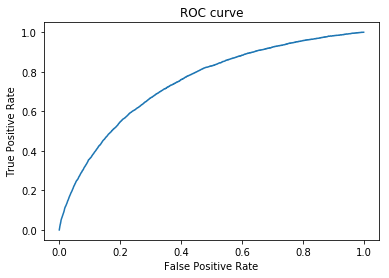

In [9]:
from sklearn import metrics

#ｆｐｒ、tpr、閾値を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_proba_logistic[:, 1])

#ROC曲線をプロット
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUCを求める関数を作成する手順  
①予測スコアとラベルをデータフレーム化し、予測スコアの降順でソート(df_auc_calculation)  
②関数を作成
　曲線の面積を求めるので、イメージ的には積分。  
　false_positiveの増加分×true_positiveの増加分で出来たの長方形の面積の逐次計算。  
　最後に面積の最大値であるfalse_positive×true_positiveとの割合を求める。

In [10]:
#予測スコアとラベルをデータフレーム化、予測スコア降順でソート
df_auc_calculation = pd.DataFrame({
    'score': y_predict_proba_logistic[:, 1],
    'label': y_test
}).sort_values('score', ascending=False)

In [11]:
#AUCを計算する式
def calculate_auc():
    true_positive = 0
    false_positive = 0
    sum = 0

    for i in df_auc_calculation[['label']].values.flatten():
        if i == 1:
            true_positive += 1
        else:
            sum += true_positive
            false_positive += 1
            
    total = sum / (true_positive * false_positive)
    
    return total

In [12]:
calculate_auc()

0.7459586960139055

In [13]:
#sklearnに用意されているAUC算出関数
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_predict_proba_logistic[:, 1])

0.7459586960139055

自作関数とroc_auc_scoreで求めた数値は同値であった。  
Kaggleで算出されたAUC0.54と算出したAUC0.74には大きな差があった。  
recallが低いということはFNが多かったということなので、Negativeと判断して間違えていたものが多い。  
元々のデータに偏り（おおよそ9:1）があったことが考えられる。  
さらに学習データとテストデータ分割でpositive:negative = 9:1になっていない可能性がある。  
問題３ではクラスのバランスを保持したまま分割させて精度を確認する。  
また、学習を１度だけでなく割合保持したまま複数回実施したほうがいいと考えられるがデータ数が多いので難しい。

## 【問題3】前処理・Feature Engineering・学習

In [16]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([212021,  18612]))

In [17]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([70665,  6213]))

76878

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighbors=5の場合で学習
neigh_5nn = KNeighborsClassifier(n_neighbors=5)
neigh_5nn.fit(X_train, y_train)

y_predict_neigh_5nn = neigh_5nn.predict(X_test)

In [ ]:
#パラメータn_neighbors=3の場合で学習
neigh_3nn = KNeighborsClassifier(n_neighbors=3)
neigh_3nn.fit(X_train, y_train)
y_predict_neigh_3nn = neigh_3nn.predict(X_test)

In [ ]:
#パラメータn_neighbors=1で学習
neigh_1nn = KNeighborsClassifier(n_neighbors=1)
neigh_1nn.fit(X_train, y_train)
y_predict_neigh_1nn = neigh_1nn.predict(X_test)

In [ ]:
accuracy_score(y_test, y_predict_neigh_5nn)

In [ ]:
accuracy_score(y_test, y_predict_neigh_3nn)

In [ ]:
accuracy_score(y_test, y_predict_neigh_1nn)

In [ ]:
precision_score(y_test, y_predict_neigh_5nn)

In [ ]:
precision_score(y_test, y_predict_neigh_3nn)

In [ ]:
precision_score(y_test, y_predict_neigh_1nn)

In [ ]:
recall_score(y_test, y_predict_neigh_5nn)

In [ ]:
recall_score(y_test, y_predict_neigh_3nn)

In [ ]:
recall_score(y_test, y_predict_neigh_1nn)

In [ ]:
f1_score(y_test, y_predict_neigh_5nn)

In [ ]:
f1_score(y_test, y_predict_neigh_3nn)

In [ ]:
f1_score(y_test, y_predict_neigh_1nn)

In [ ]:
estimation_neigh_dict = {
    "accuracy": accuracy_score(y_test, y_predict_neigh_1nn),
    "precision": precision_score(y_test, y_predict_neigh_1nn),
    "recall": recall_score(y_test, y_predict_neigh_1nn) ,
    "f1":f1_score(y_test, y_predict_neigh_1nn)
}
estimation_neigh = pd.DataFrame(estimation_neigh_dict, index=['KNeighborsClassifier'])

estimation_neigh

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression().fit(X_train, y_train)
y_predict_logistic = clf_logistic.predict(X_test)

estimation_logistic_dict = {
    "accuracy": accuracy_score(y_test, y_predict_logistic),
    "precision": precision_score(y_test, y_predict_logistic),
    "recall": recall_score(y_test, y_predict_logistic),
    "f1":f1_score(y_test, y_predict_logistic)
}

estimation_logistic = pd.DataFrame(estimation_logistic_dict, index=['LogisticRegression'])
estimation_logistic

In [ ]:
from sklearn.svm import SVC

clf_svc = SVC().fit(X_train, y_train)
y_predict_svc = clf_svc.predict(X_test)

estimation_svc_dict = {
    "accuracy": accuracy_score(y_test, y_predict_svc),
    "precision": precision_score(y_test, y_predict_svc),
    "recall": recall_score(y_test, y_predict_svc),
    "f1":f1_score(y_test, y_predict_svc)
}

estimation_svc = pd.DataFrame(estimation_svc_dict, index=['Support Vector Classification'])
estimation_svc

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf_dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_predict_dtc = clf_dtc.predict(X_test)

estimation_dtc_dict = {
    "accuracy": accuracy_score(y_test, y_predict_dtc),
    "precision": precision_score(y_test, y_predict_dtc),
    "recall": recall_score(y_test, y_predict_dtc),
    "f1":f1_score(y_test, y_predict_dtc)
}
estimation_dtc = pd.DataFrame(estimation_dtc_dict, index=['DecisionTreeClassifier'])
estimation_dtc

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rfc = RandomForestClassifier().fit(X_train, y_train)
y_predict_rfc = clf_rfc.predict(X_test)

estimation_rfc_dict = {
    "accuracy": accuracy_score(y_test, y_predict_rfc),
    "precision": precision_score(y_test, y_predict_rfc),
    "recall": recall_score(y_test, y_predict_rfc),
    "f1":f1_score(y_test, y_predict_rfc)
}
estimation_rfc = pd.DataFrame(estimation_rfc_dict, index=['RandomForestClassifier'])
estimation_rfc